## UPOZORENJA
- ćelija za učitavanje podataka treba malo više vremena (get_user_data), pozvati jednom i nakon toga zakomentirati

## TODO-ovi
- smisliti kako ćemo odabrati bolji dio podataka

In [1]:
import numpy as np
from scipy.sparse import csc_matrix, bmat
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

## Data preparation
- reading user data from given files (we are considering only users that are in some group here)
- random sample of filtered users
- normalizing user data (renaming users to elements of $\{0, ..., n-1\}$)

In [2]:
def normalize_users(users):
    usrs = list(set(users.keys()).union(set([link  for key in users for link in users[key]["links"] ])))
    groups = list(set([group for key in users for group in users[key]["groups"] ]))
    normalized_users = {}
    for user in users:
        normalized_users[usrs.index(user)] = {}
        normalized_users[usrs.index(user)]["links"] = [usrs.index(link) for link in users[user]["links"]]
        normalized_users[usrs.index(user)]["groups"] = [groups.index(group) for group in users[user]["groups"]]
    return normalized_users    

In [3]:
def filter_users(user_number, users):
    # add any additional filters here if needed (ex. at least 2 groups and 3 links)
    
    # filters like this will work only if set for groups because in the next step we are 
    # filtering links that aren't in our subgraph
    
    keys = random.sample(users.keys(), user_number)
    users = {key: users[key] for key in keys}
    
    #first eliminate any links that remained in the graph and shouldn't be there
    for user in users:
        users[user]["links"] = list(filter(lambda link: link in users.keys(), users[user]["links"]))
        
    return normalize_users(users)

In [4]:
def get_user_data(links_path, groups_path):
    # return all user data where every user is in at least one group
    links = np.loadtxt(links_path)
    groups = np.loadtxt(groups_path)
    users = {} # key is user, value is dict containing all of his links and all of his groups
    
    for edge in groups:
        if edge[0] not in users:
            users[edge[0]] = { "links": [], "groups":[] }
        users[edge[0]]["groups"].append(edge[1])
        
    for link in links:
        if link[0] in users:
            users[link[0]]["links"].append(link[1])
        if link[1] in users:
            users[link[1]]["links"].append(link[0])
    
    return users

In [5]:
def get_adjacency_matrix(users, key, row_num, col_num):
    # constructs adjacaeny matrix
    # rows are indexed by user
    # cols are indexed based on the key
    row = np.array([])
    column = np.array([])
    value = np.array([])
    
    for user in users:
        for element in users[user][key]:
            row = np.append(row, user)
            column = np.append(column, element)
            value = np.append(value, 1)
    
    s = csc_matrix((value, (row, column)), shape = (row_num, col_num))
    return s

In [8]:
# load data
# this takes some time so comment it out after first run
#%time users = get_user_data("data/release-youtube-links.txt", "data/release-youtube-groupmemberships.txt")

CPU times: user 26.7 s, sys: 190 ms, total: 26.9 s
Wall time: 26.8 s


In [11]:
# number of users
# WARNING: small number of users will usually result in a small number of links between users
k = 1000

In [12]:
filtered_users = filter_users(k, users)

In [14]:
# S matrix, matrix of links between users
s = get_adjacency_matrix(filtered_users, "links", len(filtered_users), len(filtered_users))
s

<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 70 stored elements in Compressed Sparse Column format>

In [15]:
# A matrix, affiliation matrix, links between users and groups
# how many groups are there?
a = get_adjacency_matrix(filtered_users, "groups", len(filtered_users), len(set([group for user in filtered_users for group in filtered_users[user]["groups"]])))
a

<1000x1846 sparse matrix of type '<class 'numpy.float64'>'
	with 2853 stored elements in Compressed Sparse Column format>

## Dalje nisam dirao 

In [10]:
"pogledaj sve indekse (i,j) gdje je A[i,j] = 1 i uzmi random 30% takvih"
a = a.toarray()
ones = np.transpose(a.nonzero())
indices = np.random.randint(ones.shape[0], size = int(ones.shape[0]*0.3))

In [11]:
"za test spremi citavu a, za trening izbaci onih 30%"
a_test = csc_matrix(a)
for i in range(len(indices)):
    a[ones[indices][i][0], ones[indices][i][1]] = 0
a_train = csc_matrix(a)

In [12]:
"testni podaci"
a_test

<1000x1874 sparse matrix of type '<class 'numpy.float64'>'
	with 2882 stored elements in Compressed Sparse Column format>

In [13]:
"trening podaci"
a_train

<1000x1874 sparse matrix of type '<class 'numpy.float64'>'
	with 2146 stored elements in Compressed Sparse Column format>

In [14]:
"parametar koji mnozi s"
alpha = 1

In [15]:
"citava matrica za trening"
c_train = bmat([[alpha*s, a_train], [a_train.transpose(), None]])
c_train

<2874x2874 sparse matrix of type '<class 'numpy.float64'>'
	with 4366 stored elements in COOrdinate format>

In [16]:
"citava matrica za test"
c_test = bmat([[alpha*s, a_test], [a_test.transpose(), None]])
c_test

<2874x2874 sparse matrix of type '<class 'numpy.float64'>'
	with 5838 stored elements in COOrdinate format>

In [17]:
print(s.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [18]:
print(a_test.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
print(c_test.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [20]:
print(np.power(c_test,7).toarray())

[[  0.   0.   0. ... 461.   6.   6.]
 [  0.   0.   0. ...  69.   1.   1.]
 [  0.   0.   0. ... 121.   3.   3.]
 ...
 [461.  69. 121. ...   0.   0.   0.]
 [  6.   1.   3. ...   0.   0.   0.]
 [  6.   1.   3. ...   0.   0.   0.]]


In [21]:
def katz(t, beta, k):
    katz = beta*t
    a = beta*t
    for i in range(k-1):
        a = beta*a@t
        katz = katz + a
    return katz

In [22]:
def katz_2(t, beta, k):
    t = t.astype(np.float64)
    u, s, vt = svds(t, k=3)
    s = np.diag(s)
    
    vtu = vt@u
    svtu = s@vtu
    
    katz = beta*s
    #a = beta*svtu
    small_matrix = beta * s @ vtu
    for i in range(k-1):
        small_matrix = beta * small_matrix @ s
        katz = katz + small_matrix
        small_matrix = small_matrix @ vtu
    katz = u @ katz @ vt
    return katz

In [23]:
print(c_test.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
print(katz(c_test, beta = 0.1, k = 3).toarray())

[[0.05 0.   0.   ... 0.   0.   0.  ]
 [0.   0.03 0.   ... 0.   0.   0.  ]
 [0.   0.   0.02 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.01 0.   0.  ]
 [0.   0.   0.   ... 0.   0.01 0.01]
 [0.   0.   0.   ... 0.   0.01 0.01]]


In [25]:
katz_2(c_test, beta = 0.1, k = 3)

array([[1.11455436e-06, 7.22894300e-06, 1.83468090e-08, ...,
        5.45975016e-07, 7.11999257e-09, 7.11999257e-09],
       [7.22894300e-06, 7.19854267e-05, 2.19993470e-07, ...,
        5.31176075e-06, 6.92064163e-08, 6.92064163e-08],
       [1.83468090e-08, 2.19993470e-07, 7.06153136e-10, ...,
        1.69491073e-08, 2.20819661e-10, 2.20819661e-10],
       ...,
       [5.45975016e-07, 5.31176075e-06, 1.69491073e-08, ...,
        8.30085735e-08, 1.06161933e-09, 1.06161933e-09],
       [7.11999257e-09, 6.92064163e-08, 2.20819661e-10, ...,
        1.06161933e-09, 1.35713768e-11, 1.35713768e-11],
       [7.11999257e-09, 6.92064163e-08, 2.20819661e-10, ...,
        1.06161933e-09, 1.35713768e-11, 1.35713768e-11]])

In [26]:
np.linalg.matrix_rank(c_test.toarray())

1652

In [29]:
"svd ranga k trening matrice"
# bacilo mi error nez zas %%time
c_train = c_train.astype(np.float64)
"todo:trenirat k"
u, sig, vt = svds(c_train, k = 100)

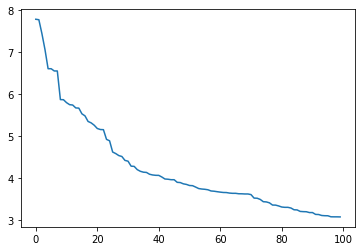

In [30]:
"singularne vrijednosti"
plt.plot(sig[::-1])

In [31]:
"vrati precision i recall na testu za jednog usera"
def evaluate(i, predictions):
    "i = user za kojeg generiramo recommendatione, predictions = broj recommendationa koji cemo ponuditi"
    score1 = (u[i-1,:]@np.diag(sig)@vt)[-a.shape[1]:]
    true_labels = c_test.getrow(i-1).toarray().flatten()[-a.shape[1]:]

    recommendations = np.flip(np.argsort(score1))[:predictions]
    
    true_positives = np.unique(true_labels[recommendations] == 1, return_counts = True)[1][1] if np.unique(true_labels[recommendations] == 1, return_counts = True)[1].shape[0] == 2\
                                              else np.unique(true_labels[recommendations] == 1, return_counts = True)[1][0] * np.unique(true_labels[recommendations] == 1, return_counts = True)[0][0]
    
    positives = np.unique(true_labels, return_counts = True)[1][1] if np.unique(true_labels, return_counts = True)[1].shape[0] == 2\
                                                                   else np.unique(true_labels, return_counts = True)[1][0] * np.unique(true_labels, return_counts = True)[0][0]
    precision = true_positives/predictions 
    recall = true_positives/positives if positives != 0 else 1

    return precision, recall

In [32]:
"evaluiraj za sve usere i svakom daj neki fiksni broj recommendationa"
stats = []
for i in tqdm(range(s.shape[0])):
    stats.append(evaluate(i = i, predictions = 5))
stats = np.array(stats)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1024.62it/s]


In [33]:
"precision i recall prosjecno po useru za gornji test"
mean_precision = np.mean(stats[:,0])
mean_recall = np.mean(stats[:,1])

mean_precision, mean_recall

(0.15159999999999998, 0.27552491065865675)

In [34]:
"variraj broj recommendationa od 1 do 50 i za svaki izracunaj prosjecni precision i recall po useru, traje oko 1h za 10k usera (Python <3)"
pr_and_recall = []
for n in tqdm(range(50)):
    stats = []
    for i in range(s.shape[0]):
        stats.append(evaluate(i = i, predictions = n+1))
    stats = np.array(stats)
    mean_precision = np.mean(stats[:,0])
    mean_recall = np.mean(stats[:,1])
    pr_and_recall.append((mean_precision, mean_recall))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.06it/s]


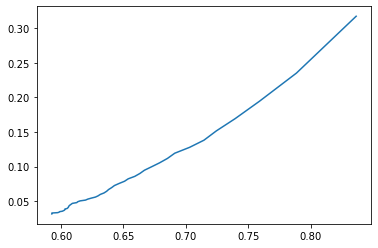

In [35]:
"graf iz papera, x = 1-recall, y = precision"
pr = np.array(pr_and_recall)
plt.plot(1 - pr[:,1], pr[:,0])

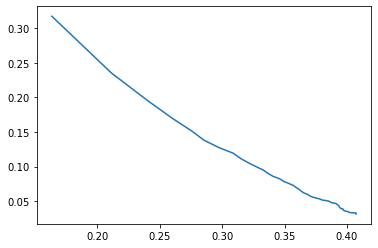

In [36]:
"x = recall, y = precision"
plt.plot(pr[:,1], pr[:,0])

In [37]:
np.savetxt("data/results.csv", pr, delimiter=",")

In [38]:
import pandas as pd
r = pd.read_csv("data/results.csv", header = None, names=["Precision", "Recall"])

In [39]:
r.head()

,Precision,Recall
0,0.317000,0.163446
1,0.235000,0.211311
2,0.194333,0.240992
3,0.169250,0.260474
4,0.151600,0.275525


In [40]:
counts = []
for i in range(a.shape[0]):
    counts.append(np.sum(a[i,:]))

In [41]:
np.mean(counts), np.min(counts), np.max(counts), np.median(counts)

(2.146, 0.0, 42.0, 1.0)

In [42]:
unique, frequencies = np.unique(counts, return_counts=True)
print(np.asarray((unique, frequencies)).T)

[[  0. 156.]
 [  1. 504.]
 [  2. 140.]
 [  3.  53.]
 [  4.  44.]
 [  5.  18.]
 [  6.  18.]
 [  7.  17.]
 [  8.  11.]
 [  9.  11.]
 [ 10.   2.]
 [ 11.   2.]
 [ 12.   2.]
 [ 13.   4.]
 [ 14.   2.]
 [ 15.   3.]
 [ 16.   3.]
 [ 17.   2.]
 [ 18.   1.]
 [ 21.   1.]
 [ 22.   1.]
 [ 32.   1.]
 [ 33.   1.]
 [ 41.   2.]
 [ 42.   1.]]
